<a href="https://colab.research.google.com/github/TurkuNLP/textual-data-analysis-course/blob/main/train_finnish_ner_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Finnish NER model

Train a Finnish Named Entity model. This notebook largely follows the [sequence labeling example notebook](https://github.com/TurkuNLP/textual-data-analysis-course/blob/main/sequence_labeling_example.ipynb).

---

## Setup

Install the required Python packages:

In [1]:
!pip install --quiet transformers datasets evaluate seqeval

Import the libraries we'll be using here.

In [2]:
import datasets
import transformers
import evaluate

from pprint import pprint

Make things a bit more quiet. (This only affects what shows on screen when running. If you're debugging, you probably want to comment these out.)

In [3]:
transformers.utils.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()
datasets.disable_progress_bar()

---

## Load dataset

Load a dataset for training using `datasets`.

In [4]:
DATASET = 'turku_ner_corpus'

builder = datasets.load_dataset_builder(DATASET)
dataset = datasets.load_dataset(DATASET)

Let's have a look at the description and dataset.

In [5]:
print(builder.info.description)

An open, broad-coverage corpus for Finnish named entity recognition presented in Luoma et al. (2020) A Broad-coverage Corpus for Finnish Named Entity Recognition.



In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 12217
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1364
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1555
    })
})


We have the conventional split into `train`, `validation`, and `test`.

We're here only interested in the `tokens` and `ner_tags`. (In particular, the `ner_tags` and `chunk_tags` are included to support methods based on manually engineered features, and as such not highly relevant to the deep learning approach we're pursuing here.)

Let's have a look at one example.

In [7]:
print(dataset['train'][5]['tokens'])
print(dataset['train'][5]['ner_tags'])

['Että', 'Aninkaisten', 'silta', 'on', 'muka', 'tuolla', ',', 'vai', '?']
[12, 2, 8, 12, 12, 12, 12, 12, 12]


Take note of the number of different labels and create mappings from label IDs to label strings and vice versa; we'll need these later.

In [8]:
label_names = dataset['train'].features['ner_tags'].feature.names
print('Labels:', label_names)

num_labels = len(label_names)
id2label = { k: v for k, v in enumerate(label_names) }
label2id = { v: k for k, v in enumerate(label_names) }

print('Number of labels:', num_labels)
print('id2label mapping:', id2label)
print('labelid2 mapping:', label2id)

Labels: ['B-DATE', 'B-EVENT', 'B-LOC', 'B-ORG', 'B-PER', 'B-PRO', 'I-DATE', 'I-EVENT', 'I-LOC', 'I-ORG', 'I-PER', 'I-PRO', 'O']
Number of labels: 13
id2label mapping: {0: 'B-DATE', 1: 'B-EVENT', 2: 'B-LOC', 3: 'B-ORG', 4: 'B-PER', 5: 'B-PRO', 6: 'I-DATE', 7: 'I-EVENT', 8: 'I-LOC', 9: 'I-ORG', 10: 'I-PER', 11: 'I-PRO', 12: 'O'}
labelid2 mapping: {'B-DATE': 0, 'B-EVENT': 1, 'B-LOC': 2, 'B-ORG': 3, 'B-PER': 4, 'B-PRO': 5, 'I-DATE': 6, 'I-EVENT': 7, 'I-LOC': 8, 'I-ORG': 9, 'I-PER': 10, 'I-PRO': 11, 'O': 12}


Let's see that example again, applying the label mapping:

In [9]:
for token, tag_id in zip(dataset['train'][5]['tokens'], dataset['train'][5]['ner_tags']):
    print(f'{token}\t{id2label[tag_id]}')

Että	O
Aninkaisten	B-LOC
silta	I-LOC
on	O
muka	O
tuolla	O
,	O
vai	O
?	O


---

## Tokenize and vectorize dataset

As in the [text classification notebook](https://github.com/TurkuNLP/textual-data-analysis-course/blob/main/text_classification_basic_example.ipynb), we'll first load the tokenizer that corresponds to the model that we want to use. `AutoTokenizer` is a convenience class that will return the appropriate tokenizer for the model it's given as an argument:

In [10]:
MODEL = 'TurkuNLP/bert-base-finnish-cased-v1'

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)

For tokenization, we'll two functions from [a transformers tutorial](https://huggingface.co/course/chapter7/2).

In [11]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:    # Start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:          # Special token            
            new_labels.append(-100)
        else:                          # Same word as previous token
            label = labels[word_id]
            if label % 2 == 1:         # If label is B-XXX we change it to I-XXX
                label += 1
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(inputs):
    outputs = tokenizer(inputs['tokens'], truncation=True, is_split_into_words=True)
    new_labels = []
    for i, labels in enumerate(inputs['ner_tags']):
        word_ids = outputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    outputs['labels'] = new_labels
    return outputs

We'll then apply this to the whole dataset:

In [12]:
dataset = dataset.map(tokenize_and_align_labels, batched=True)

Now these should match up:

In [13]:
from itertools import zip_longest

token_ids = dataset['train'][5]['input_ids']
tag_ids = dataset['train'][5]['labels']

for token_id, tag_id in zip_longest(token_ids, tag_ids):
    token = tokenizer.convert_ids_to_tokens(token_id)
    tag = id2label[tag_id] if tag_id != -100 else None
    print(f'{token}\t{tag}')

[CLS]	None
Että	O
An	B-LOC
##inka	B-LOC
##isten	B-LOC
silta	I-LOC
on	O
muka	O
tuolla	O
,	O
vai	O
?	O
[SEP]	None


---

## Instantiate model

Now, we'll instantiate a pretrained model with a sequence labeling head. In the `transformers` library, this class of models are named `...ModelForTokenClassification`. (cf. `...ModelForSequenceClassification`) We'll again use the `Auto` variant to get the appropriate class based on model name.

**NOTE**: we need to provide the number of labels to `from_pretrained` so that the function knows the size of the output layer that is required. The `id2label` and `label2id` mappings allow the model to report its classification results in interpretable text labels.

In [14]:
model = transformers.AutoModelForTokenClassification.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

---

## Training configuration

To assess the progress and results of training, we'll use the standard `seqeval` library. We'll also need to introduce a function that takes model outputs and the labels from the dataset and calls the metric.

Here, we'll again borrow from [the transformers tutorial](https://huggingface.co/course/chapter7/2):

In [15]:
metrics = evaluate.load('seqeval')


def compute_metrics(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[i] for i in label if i != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metrics.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': all_metrics['overall_precision'],
        'recall': all_metrics['overall_recall'],
        'f1': all_metrics['overall_f1'],
        'accuracy': all_metrics['overall_accuracy'],
    }

We'll also need a collator for padding the examples to the same length to process them in batches.

In [16]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

The `TrainingArguments` class configures many of the details of the model training. You may want to try optimizing the following hyperparameters to improve model performance:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per training batch
* `max_steps`: the maximum number of steps to train for

In [17]:
trainer_args = transformers.TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='steps',
    logging_strategy='steps',
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    max_steps=3000,
)

Finally, we'll create a custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [18]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

---

## Train (fine-tune) model

In [19]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[training_logs], 
)

max_steps is given, it will override any value given in num_train_epochs


In [20]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12217
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3000
  Number of trainable parameters = 123941389
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method i

{'loss': 0.4276, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.13}


/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.15534868836402893, 'eval_precision': 0.6746458231558378, 'eval_recall': 0.6384650947757744, 'eval_f1': 0.6560570071258908, 'eval_accuracy': 0.9552197694093574, 'eval_runtime': 5.2229, 'eval_samples_per_second': 261.156, 'eval_steps_per_second': 8.233, 'epoch': 0.13}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.1437, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.26}
{'eval_loss': 0.11087382584810257, 'eval_precision': 0.7636449928808733, 'eval_recall': 0.7438742487286176, 'eval_f1': 0.7536299765807962, 'eval_accuracy': 0.9675363003187345, 'eval_runtime': 5.0396, 'eval_samples_per_second': 270.659, 'eval_steps_per_second': 8.532, 'epoch': 0.26}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.1018, 'learning_rate': 1.8e-05, 'epoch': 0.39}
{'eval_loss': 0.10081682354211807, 'eval_precision': 0.8336755646817249, 'eval_recall': 0.7508090614886731, 'eval_f1': 0.7900754074434444, 'eval_accuracy': 0.9705268956833117, 'eval_runtime': 5.0597, 'eval_samples_per_second': 269.58, 'eval_steps_per_second': 8.498, 'epoch': 0.39}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0967, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.52}
{'eval_loss': 0.09584654122591019, 'eval_precision': 0.8357107722577471, 'eval_recall': 0.7854831252889505, 'eval_f1': 0.809818875119161, 'eval_accuracy': 0.9743438397670484, 'eval_runtime': 4.8705, 'eval_samples_per_second': 280.052, 'eval_steps_per_second': 8.829, 'epoch': 0.52}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0839, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.65}


Saving model checkpoint to checkpoints/checkpoint-500
Configuration saved in checkpoints/checkpoint-500/config.json


{'eval_loss': 0.08102676272392273, 'eval_precision': 0.8421300659754948, 'eval_recall': 0.8261673601479427, 'eval_f1': 0.8340723453908985, 'eval_accuracy': 0.9779246842167395, 'eval_runtime': 5.0143, 'eval_samples_per_second': 272.021, 'eval_steps_per_second': 8.575, 'epoch': 0.65}


Model weights saved in checkpoints/checkpoint-500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0609, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.79}
{'eval_loss': 0.07986181974411011, 'eval_precision': 0.8185134518923849, 'eval_recall': 0.8298659269533056, 'eval_f1': 0.8241505968778696, 'eval_accuracy': 0.9779246842167395, 'eval_runtime': 5.039, 'eval_samples_per_second': 270.691, 'eval_steps_per_second': 8.534, 'epoch': 0.79}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0793, 'learning_rate': 1.5333333333333334e-05, 'epoch': 0.92}
{'eval_loss': 0.06019490584731102, 'eval_precision': 0.8620689655172413, 'eval_recall': 0.8668515950069348, 'eval_f1': 0.8644536652835408, 'eval_accuracy': 0.9823712273245977, 'eval_runtime': 4.9818, 'eval_samples_per_second': 273.796, 'eval_steps_per_second': 8.631, 'epoch': 0.92}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0713, 'learning_rate': 1.4666666666666666e-05, 'epoch': 1.05}
{'eval_loss': 0.06654392182826996, 'eval_precision': 0.8632958801498127, 'eval_recall': 0.8525196486361535, 'eval_f1': 0.8578739241684114, 'eval_accuracy': 0.9817416283004762, 'eval_runtime': 5.3304, 'eval_samples_per_second': 255.891, 'eval_steps_per_second': 8.067, 'epoch': 1.05}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0357, 'learning_rate': 1.4e-05, 'epoch': 1.18}
{'eval_loss': 0.07347707450389862, 'eval_precision': 0.8778987221959299, 'eval_recall': 0.8576051779935275, 'eval_f1': 0.8676333021515436, 'eval_accuracy': 0.9830008263487192, 'eval_runtime': 4.8987, 'eval_samples_per_second': 278.443, 'eval_steps_per_second': 8.778, 'epoch': 1.18}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.034, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.31}


Saving model checkpoint to checkpoints/checkpoint-1000
Configuration saved in checkpoints/checkpoint-1000/config.json


{'eval_loss': 0.07904626429080963, 'eval_precision': 0.8630725190839694, 'eval_recall': 0.8363384188626907, 'eval_f1': 0.849495186663536, 'eval_accuracy': 0.9806004800692559, 'eval_runtime': 4.9885, 'eval_samples_per_second': 273.427, 'eval_steps_per_second': 8.62, 'epoch': 1.31}


Model weights saved in checkpoints/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-1000/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0334, 'learning_rate': 1.2666666666666667e-05, 'epoch': 1.44}
{'eval_loss': 0.07536164671182632, 'eval_precision': 0.8795761078998073, 'eval_recall': 0.8441978733240869, 'eval_f1': 0.8615239443264922, 'eval_accuracy': 0.9819777279345216, 'eval_runtime': 4.9927, 'eval_samples_per_second': 273.201, 'eval_steps_per_second': 8.613, 'epoch': 1.44}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0334, 'learning_rate': 1.2e-05, 'epoch': 1.57}
{'eval_loss': 0.06986343115568161, 'eval_precision': 0.8963210702341137, 'eval_recall': 0.8673139158576052, 'eval_f1': 0.881578947368421, 'eval_accuracy': 0.9840239247629167, 'eval_runtime': 4.9426, 'eval_samples_per_second': 275.969, 'eval_steps_per_second': 8.7, 'epoch': 1.57}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0325, 'learning_rate': 1.1333333333333334e-05, 'epoch': 1.7}
{'eval_loss': 0.0634743794798851, 'eval_precision': 0.8836668217775709, 'eval_recall': 0.8779472954230236, 'eval_f1': 0.8807977736549165, 'eval_accuracy': 0.9839058749458939, 'eval_runtime': 5.0126, 'eval_samples_per_second': 272.116, 'eval_steps_per_second': 8.578, 'epoch': 1.7}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0334, 'learning_rate': 1.0666666666666667e-05, 'epoch': 1.83}
{'eval_loss': 0.06323889642953873, 'eval_precision': 0.8820250812819321, 'eval_recall': 0.8779472954230236, 'eval_f1': 0.8799814643188137, 'eval_accuracy': 0.9831975760437571, 'eval_runtime': 4.9621, 'eval_samples_per_second': 274.884, 'eval_steps_per_second': 8.666, 'epoch': 1.83}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0273, 'learning_rate': 1e-05, 'epoch': 1.96}


Saving model checkpoint to checkpoints/checkpoint-1500
Configuration saved in checkpoints/checkpoint-1500/config.json


{'eval_loss': 0.06135089322924614, 'eval_precision': 0.8818350324374421, 'eval_recall': 0.8797965788257051, 'eval_f1': 0.880814626243925, 'eval_accuracy': 0.9841419745799393, 'eval_runtime': 4.951, 'eval_samples_per_second': 275.502, 'eval_steps_per_second': 8.685, 'epoch': 1.96}


Model weights saved in checkpoints/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-1500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-1500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0212, 'learning_rate': 9.333333333333334e-06, 'epoch': 2.09}
{'eval_loss': 0.06780312955379486, 'eval_precision': 0.8777111213659436, 'eval_recall': 0.8793342579750347, 'eval_f1': 0.8785219399538107, 'eval_accuracy': 0.9831188761657419, 'eval_runtime': 4.9494, 'eval_samples_per_second': 275.59, 'eval_steps_per_second': 8.688, 'epoch': 2.09}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0148, 'learning_rate': 8.666666666666668e-06, 'epoch': 2.23}
{'eval_loss': 0.07192112505435944, 'eval_precision': 0.8925035360678925, 'eval_recall': 0.8751733703190014, 'eval_f1': 0.8837535014005603, 'eval_accuracy': 0.9845354739700154, 'eval_runtime': 4.9546, 'eval_samples_per_second': 275.298, 'eval_steps_per_second': 8.679, 'epoch': 2.23}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0133, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.36}
{'eval_loss': 0.07085469365119934, 'eval_precision': 0.8996194100856327, 'eval_recall': 0.8742487286176607, 'eval_f1': 0.8867526377491207, 'eval_accuracy': 0.9842600243969621, 'eval_runtime': 4.9205, 'eval_samples_per_second': 277.21, 'eval_steps_per_second': 8.739, 'epoch': 2.36}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0117, 'learning_rate': 7.333333333333333e-06, 'epoch': 2.49}
{'eval_loss': 0.07215847820043564, 'eval_precision': 0.8947619047619048, 'eval_recall': 0.8687008784096163, 'eval_f1': 0.881538822425522, 'eval_accuracy': 0.9836697753118483, 'eval_runtime': 5.6124, 'eval_samples_per_second': 243.034, 'eval_steps_per_second': 7.662, 'epoch': 2.49}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0128, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.62}


Saving model checkpoint to checkpoints/checkpoint-2000
Configuration saved in checkpoints/checkpoint-2000/config.json


{'eval_loss': 0.07505478709936142, 'eval_precision': 0.8840982846546129, 'eval_recall': 0.8816458622283865, 'eval_f1': 0.8828703703703704, 'eval_accuracy': 0.9845354739700154, 'eval_runtime': 4.9402, 'eval_samples_per_second': 276.101, 'eval_steps_per_second': 8.704, 'epoch': 2.62}


Model weights saved in checkpoints/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-2000/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-2000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0149, 'learning_rate': 6e-06, 'epoch': 2.75}
{'eval_loss': 0.07546336203813553, 'eval_precision': 0.8907721280602636, 'eval_recall': 0.874711049468331, 'eval_f1': 0.8826685327735012, 'eval_accuracy': 0.9841026246409318, 'eval_runtime': 4.9539, 'eval_samples_per_second': 275.339, 'eval_steps_per_second': 8.68, 'epoch': 2.75}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0126, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.88}
{'eval_loss': 0.06679240614175797, 'eval_precision': 0.8923578751164958, 'eval_recall': 0.8853444290337494, 'eval_f1': 0.8888373172429798, 'eval_accuracy': 0.9849289733600913, 'eval_runtime': 5.113, 'eval_samples_per_second': 266.771, 'eval_steps_per_second': 8.41, 'epoch': 2.88}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0117, 'learning_rate': 4.666666666666667e-06, 'epoch': 3.01}
{'eval_loss': 0.06956109404563904, 'eval_precision': 0.888262910798122, 'eval_recall': 0.874711049468331, 'eval_f1': 0.8814348940135103, 'eval_accuracy': 0.9837091252508559, 'eval_runtime': 4.9482, 'eval_samples_per_second': 275.657, 'eval_steps_per_second': 8.69, 'epoch': 3.01}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0074, 'learning_rate': 4.000000000000001e-06, 'epoch': 3.14}
{'eval_loss': 0.0674944818019867, 'eval_precision': 0.8833563854310742, 'eval_recall': 0.8858067498844198, 'eval_f1': 0.8845798707294552, 'eval_accuracy': 0.9844174241529926, 'eval_runtime': 5.6185, 'eval_samples_per_second': 242.77, 'eval_steps_per_second': 7.653, 'epoch': 3.14}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0059, 'learning_rate': 3.3333333333333333e-06, 'epoch': 3.27}


Saving model checkpoint to checkpoints/checkpoint-2500
Configuration saved in checkpoints/checkpoint-2500/config.json


{'eval_loss': 0.06879357993602753, 'eval_precision': 0.8885767790262172, 'eval_recall': 0.8774849745723532, 'eval_f1': 0.8829960455919982, 'eval_accuracy': 0.9840632747019242, 'eval_runtime': 4.9282, 'eval_samples_per_second': 276.777, 'eval_steps_per_second': 8.725, 'epoch': 3.27}


Model weights saved in checkpoints/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-2500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-2500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0055, 'learning_rate': 2.666666666666667e-06, 'epoch': 3.4}
{'eval_loss': 0.07161697000265121, 'eval_precision': 0.8870292887029289, 'eval_recall': 0.8821081830790569, 'eval_f1': 0.8845618915159945, 'eval_accuracy': 0.9839452248849014, 'eval_runtime': 4.9937, 'eval_samples_per_second': 273.143, 'eval_steps_per_second': 8.611, 'epoch': 3.4}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.005, 'learning_rate': 2.0000000000000003e-06, 'epoch': 3.53}
{'eval_loss': 0.07181897014379501, 'eval_precision': 0.8884239888423989, 'eval_recall': 0.883495145631068, 'eval_f1': 0.8859527121001392, 'eval_accuracy': 0.9842600243969621, 'eval_runtime': 4.9555, 'eval_samples_per_second': 275.249, 'eval_steps_per_second': 8.677, 'epoch': 3.53}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0058, 'learning_rate': 1.3333333333333334e-06, 'epoch': 3.66}
{'eval_loss': 0.07260341942310333, 'eval_precision': 0.8867223769730733, 'eval_recall': 0.8830328247803976, 'eval_f1': 0.8848737549223998, 'eval_accuracy': 0.9842206744579546, 'eval_runtime': 4.9039, 'eval_samples_per_second': 278.145, 'eval_steps_per_second': 8.768, 'epoch': 3.66}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0065, 'learning_rate': 6.666666666666667e-07, 'epoch': 3.8}
{'eval_loss': 0.07291650772094727, 'eval_precision': 0.8856071261134553, 'eval_recall': 0.8733240869163199, 'eval_f1': 0.8794227188081937, 'eval_accuracy': 0.9839058749458939, 'eval_runtime': 5.3507, 'eval_samples_per_second': 254.922, 'eval_steps_per_second': 8.036, 'epoch': 3.8}


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1364
  Batch size = 32


{'loss': 0.0041, 'learning_rate': 0.0, 'epoch': 3.93}


Saving model checkpoint to checkpoints/checkpoint-3000
Configuration saved in checkpoints/checkpoint-3000/config.json


{'eval_loss': 0.07170716673135757, 'eval_precision': 0.886660447761194, 'eval_recall': 0.8788719371243643, 'eval_f1': 0.8827490132342697, 'eval_accuracy': 0.9842206744579546, 'eval_runtime': 5.147, 'eval_samples_per_second': 265.01, 'eval_steps_per_second': 8.354, 'epoch': 3.93}


Model weights saved in checkpoints/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-3000/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-3000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from checkpoints/checkpoint-1500 (score: 0.06135089322924614).


{'train_runtime': 737.1799, 'train_samples_per_second': 65.113, 'train_steps_per_second': 4.07, 'train_loss': 0.048271201928456624, 'epoch': 3.93}


TrainOutput(global_step=3000, training_loss=0.048271201928456624, metrics={'train_runtime': 737.1799, 'train_samples_per_second': 65.113, 'train_steps_per_second': 4.07, 'train_loss': 0.048271201928456624, 'epoch': 3.93})

---

## Evaluate trained model

We can use the `trainer` to evaluate the trained model using the metric we defined:

In [21]:
eval_results = trainer.evaluate(dataset['test'])

pprint(eval_results)

print('\nF1:', eval_results['eval_f1'])

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, ner_tags, tokens. If id, ner_tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1555
  Batch size = 32


{'eval_loss': 0.058864884078502655, 'eval_precision': 0.9089137847053093, 'eval_recall': 0.9071463296062227, 'eval_f1': 0.908029197080292, 'eval_accuracy': 0.9868343143742816, 'eval_runtime': 4.8017, 'eval_samples_per_second': 323.844, 'eval_steps_per_second': 10.205, 'epoch': 3.93}
{'epoch': 3.93,
 'eval_accuracy': 0.9868343143742816,
 'eval_f1': 0.908029197080292,
 'eval_loss': 0.058864884078502655,
 'eval_precision': 0.9089137847053093,
 'eval_recall': 0.9071463296062227,
 'eval_runtime': 4.8017,
 'eval_samples_per_second': 323.844,
 'eval_steps_per_second': 10.205}

F1: 0.908029197080292


As we captured performance during training using the `training_logs` callback, we can also have a look at training and evaluation loss and evaluation $F_1$ progression. (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

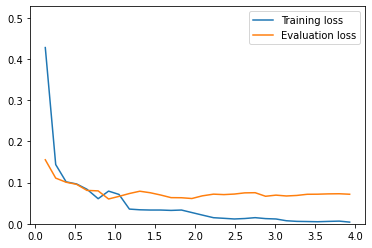

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs['epoch'], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ['loss', 'eval_loss'], ['Training loss', 'Evaluation loss'])

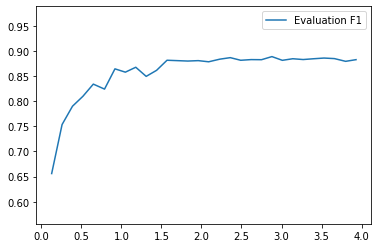

In [23]:
plot(training_logs.logs, ['eval_f1'], ['Evaluation F1'])

---

## Create pipeline



We can wrap our fine-tuned model in a pipeline for convenience. (We need to specify `device` here as the model is on GPU.)

In [24]:
pipe = transformers.pipeline(
    'token-classification',
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy='simple',
    device=0
)

We can then use the pipeline simply as follows:

In [29]:
pipe('Turku ja Tampere ovat Suomen kaupunkeja.')

[{'entity_group': 'LOC',
  'score': 0.9853655,
  'word': 'Turku',
  'start': 0,
  'end': 5},
 {'entity_group': 'LOC',
  'score': 0.99076474,
  'word': 'Tampere',
  'start': 9,
  'end': 16},
 {'entity_group': 'LOC',
  'score': 0.9982572,
  'word': 'Suomen',
  'start': 22,
  'end': 28}]

Or, for convenience

In [30]:
def tag(text):
    output = pipe(text)
    print('input:', text)
    print('output:', [(o['word'], o['entity_group']) for o in output])

tag('Turku ja Tampere ovat Suomen kaupunkeja.')

input: Turku ja Tampere ovat Suomen kaupunkeja.
output: [('Turku', 'LOC'), ('Tampere', 'LOC'), ('Suomen', 'LOC')]


In [31]:
tag('Paavo Nurmi syntyi Turussa vuonna 1897.')

input: Paavo Nurmi syntyi Turussa vuonna 1897.
output: [('Paavo Nurmi', 'PER'), ('Turussa', 'LOC'), ('vuonna 1897', 'DATE')]


In [34]:
tag('Nokia on firma joka perustettiin lähellä Nokian kaupunkia.')

input: Nokia on firma joka perustettiin lähellä Nokian kaupunkia.
output: [('Nokia', 'ORG'), ('Nokian', 'LOC')]


# Upload to hub

In [37]:
!pip install --quiet huggingface_hub

In [43]:
from huggingface_hub import notebook_login

# notebook_login()

In [40]:
trainer.model.push_to_hub('example-turku-ner-model')

Configuration saved in /tmp/tmp41czvjlb/config.json
Model weights saved in /tmp/tmp41czvjlb/pytorch_model.bin
Uploading the following files to spyysalo/example-turku-ner-model: pytorch_model.bin,config.json


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/spyysalo/example-turku-ner-model/commit/f212f11f6f78bd5594c96175539b8bcdf5479f46', commit_message='Upload BertForTokenClassification', commit_description='', oid='f212f11f6f78bd5594c96175539b8bcdf5479f46', pr_url=None, pr_revision=None, pr_num=None)

In [42]:
trainer.tokenizer.push_to_hub('example-turku-ner-model')

tokenizer config file saved in /tmp/tmpxk5r9vkh/tokenizer_config.json
Special tokens file saved in /tmp/tmpxk5r9vkh/special_tokens_map.json
Uploading the following files to spyysalo/example-turku-ner-model: vocab.txt,special_tokens_map.json,tokenizer_config.json,tokenizer.json


CommitInfo(commit_url='https://huggingface.co/spyysalo/example-turku-ner-model/commit/12aa84a1b38c5c0268362f1e01c49b99990ea113', commit_message='Upload tokenizer', commit_description='', oid='12aa84a1b38c5c0268362f1e01c49b99990ea113', pr_url=None, pr_revision=None, pr_num=None)